## Bra and Ket Definitions

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Parent Hamiltonian Complete Version

In the original parent Hamiltonian code the authors compute the same **local hamiltonian** for all the qubits of the ansatz. This is due to the particular structure of their ansatz, where all the qubits have the same structure and the same parameters. 

So they do the iteratively computations of the reduced density operators (for increasing number of free qubits) but for the first qubit. Then they use the same reduced density operator and compute the **local parent Hamiltonian** for all the qubits of the ansatz. 

This is depicted in following figure (where a locality of 4 was asumed)

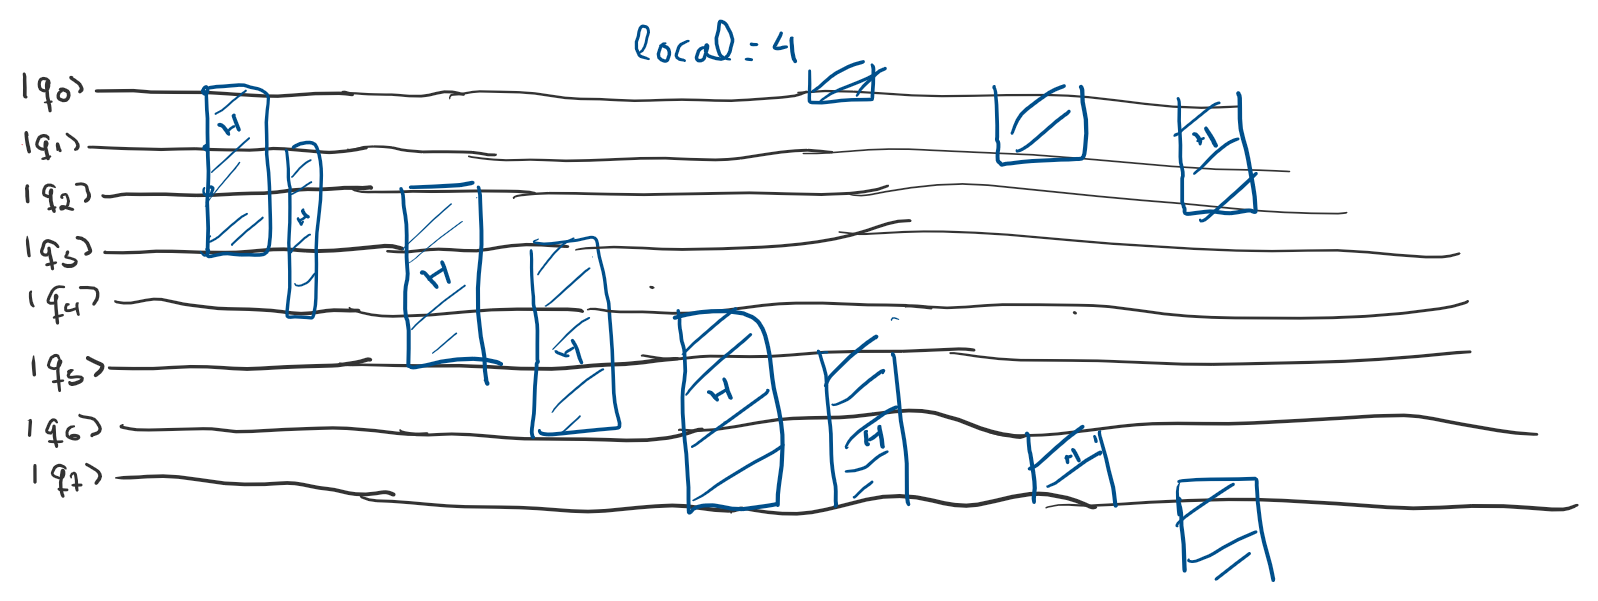

For a general ansatz the used procedure is not enough. We need to acomplish the procedure for every qubit in the ansatz. So for each qubit we need the locality (this is the number of qubits affected by the future **local parent Hamiltonian**) and the correspondent reduced density operator for computing the **local parent Hamiltonian**.

This situation is depicted in following figure:


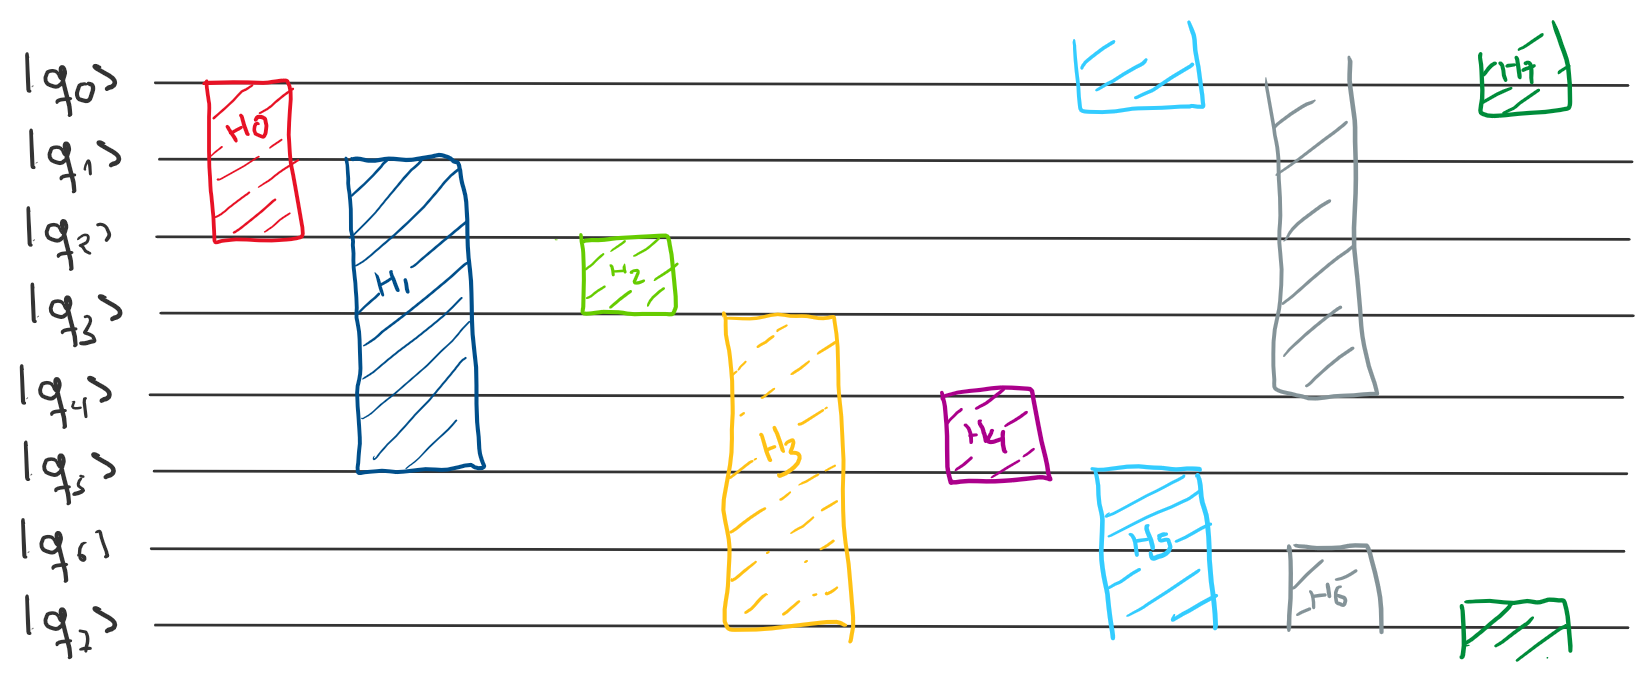

We have developed several functions for doing this procedure. In this notebook we analyze them

In [ ]:
#Python libraries
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
# QLM ansatz
import parent_hamiltonian.ansatz.ansatz_qlm as ansatz_qlm
#QLM Libraries
from qat.core import Observable, Term
#QLM QPUs
from qat.qpus import PyLinalg, CLinalg
qpu = PyLinalg()

In [ ]:
# Original Parent Hamiltonian Library
import parent_hamiltonian.japanese.parent_hamiltonian as japanese

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO
    level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
# Ansatz Library in occidental way
import parent_hamiltonian.ansatz.ansatz_mps as ansatz_mps

## 1. Random Angles

Here we generate the random angles for the $\vec{\theta}$ of the ansatz

In [ ]:
#np.random.seed(seed = 1)
depth = 3
angle_list = np.random.rand(depth*2)*2*np.pi
print("Answer_angle_list: ", angle_list)

## 2. Ansatz for Parent Hamiltonian

Here we use our developed package for computing the mps representation of the ansatz of the paper

In [ ]:
nqubit = 5

In [ ]:
%%time
mps_ansatz, index_  = ansatz_mps.nqubit_mps(nqubit, angle_list)

## 3. Computing Reduced Density Matrix

First functions we need functions for creating reduced density matrix from MPS. 

Let $\rho^{AB}$ the density matrix of a composed $AB$ system. For each system we can chose following basis:

* Subsystem A: $\{\ket{\phi_u}\}_{u=0}^{2^{N_A} -1}$
* Subsystem B: $\{\ket{\chi_v}\}_{v=0}^{2^{N_B} -1}$


the reduced density matrix $\rho_A$ is the result of trace out the system B, this is:

$$\rho_A = \text{Tr}_B(\rho^{AB}) = \sum_{v=0}^{2^{N_B} -1} \left(\mathcal{I}_A \otimes \bra{\chi_v}\right) \rho^{AB} \left(\mathcal{I}_A \otimes \ket{\chi_v}\right) $$


Aditionally we can define the reduced density matrix $\rho_B$


$$\rho_B = \text{Tr}_A(\rho^{AB}) = \sum_{u=0}^{2^{N_A} -1} \left(  \bra{\phi_u} \otimes \mathcal{I}_B \right) \rho^{AB} \left(  \ket{\phi_u} \otimes \mathcal{I}_B \right)$$


In a more general way if we suppouse that the state $\ket{\Psi}$ is a $N$ qubit system we can write, using Einstein sumation convention:

$$\ket{\Psi} = \Psi_{i_0 i_1 \cdots i_N} \ket{i_0 i_1 \cdots i_N}$$

Then the elements of the density operator will be:

$$\rho_{i_0i_1, \cdots, i_N}^{j_0j_1, \cdots, j_N} = \Psi_{i_0i_1, \cdots, i_N} \Psi_{j_0j_1, \cdots, j_N}^{\dagger}$$

Then the correspondent reduced operator for qubits $i_{k_0}, i_{k_1} \cdots i_{k_m}$ (this is the qubits we are going to trace out) will be

$$\text{Tr}_{i_{k_0}, i_{k_1} \cdots i_{k_m}} (\rho)=
\Psi_{i_0i_1\cdots i_{k_0}\cdots i_{k_1} \cdots i_{k_m} \cdots i_N} \Psi_{j_0j_1 \cdots i_{k_0}\cdots i_{k_1} \cdots i_{k_m} \cdots j_N}^{\dagger} = \rho_{i_0 i_1 \cdots i_{k_0-1} i_{k_0+1}\cdots i_{k_1-1} i_{k_1+1} \cdots i_{k_m-1} i_{k_m+1} \cdots  i_N}^{j_0 j_1 \cdots j_{k_0-1} j_{k_0+1}\cdots j_{k_1-1} j_{k_1+1} \cdots j_{k_m - 1} j_{k_m+1} \cdots j_N}
$$

The indices $i_{k_0}, i_{k_1} \cdots i_{k_m}$ **WIL NOT** appear in the final indexation.

#### Note

In the parent hamiltonian procedure for getting the reduced density matrix for computing the **local Hamiltonian** we are going to trace out consecutive qubits so we are going to trace out from qbuit $i_{k_0}$ to $i_{k_0 + m}$:

$$
\text{Tr}_{i_{k_0} i_{k_0 + 1} \cdots i_{k_0 + m}} (\rho)=\Psi_{i_0 i_1 \cdots i_{k_0 - 1} i_{k_0} i_{k_0 + 1} \cdots i_{k_0 + m} i_{k_0 + m + 1} \cdots i_N} \Psi_{j_0 j_1 \cdots j_{k_0 - 1} i_{k_0} i_{k_0 + 1} \cdots i_{k_0 + m} j_{k_0 + m + 1} \cdots j_N} = \rho_{i_0 i_1 \cdots i_{k_0 - 1} i_{k_0 + m + 1} \cdots i_N} ^{j_0 j_1 \cdots j_{k_0 - 1} j_{k_0 + m + 1} \cdots j_N}
$$

Again the qubits $i_{k_0}$ to $i_{k_0 + m}$ **do not** appear in the final indexation


In order to compute the mandatory density operator contractions we have developed the function *reduced_matrix* in the package **contractions** of the module **parent_hamiltonian.contractions**.

This function computes the reduced matrix using transpose, reshape and matrix multiplication. In order to use this function we need to provide:

* state: numpy array of the state in MPS format.
* free_indices: list with free indices for computing reduced matrix.
* contraction_indices: list with the contraction indices for computing reduced matrix.

In [ ]:
import parent_hamiltonian.contractions.contractions as contractions

In [ ]:
mps_ansatz.ndim

In [ ]:
free_indices = [0, 1]
contraction_indices = [2, 3, 4]

rho = contractions.reduced_matrix(mps_ansatz, free_indices, contraction_indices)
rho_s = contractions.reduced_matrix_string(mps_ansatz, free_indices, contraction_indices)
np.isclose(rho, rho_s).all()

In [ ]:
free_indices = [0, 1, 2, 3, 4]
contraction_indices = []

rho = contractions.reduced_matrix(mps_ansatz, free_indices, contraction_indices)
rho_s = contractions.reduced_matrix_string(mps_ansatz, free_indices, contraction_indices)
np.isclose(rho, rho_s).all()

## 4. Computing the locality.

The main approach of the original paper of the **parent hamiltonian** is try to find **local hamiltonians** for each qubit of the ansatz. This imply that first they need to compute **FOR EACH** qubit of the ansatz the qubits that will be under the same **local hamiltoninan**. This can be done by the following iterative procces:

1. Given an input qbuit they chose the qubit and inmediately next qubit.
2. They compute the reduced density matrix by tracing out all the qubits except the 2 aforementioned qubits.
3. They compute the rank of the reduced density matrix. If the rank is lower than the dimension of the matrix then the procces is stopped and the reduced density matrix is returned.
4. If the rank is equal to dimension of the reduced density matrix then they begin again from step 1 but in this case they add the following qubit to the procces.

So for each qubit a reduced density operator that affects to the qubit and several subsequent qubits whose rank is lower that its dimension it is returned.

We are going to use following notation for the computed local reduced density matrices obtained from this procedure: 

$$\rho_{i_k}^{m_k} = \Psi_{i_0 i_1 \cdots i_{k - 1} i_{k} i_{k + 1} \cdots i_{k + m_k} i_{k + m_k + 1} \cdots i_N} \Psi_{j_0 j_1 \cdots j_{k - 1} i_{k} i_{k + 1} \cdots i_{k + m_k} j_{k + m_k + 1} \cdots j_N}$$

Where:

* $i_k = 0, 1, \cdots, \text{nqubits}$
* $m_k$ are the number of qubits that will be affected by the future parent local hamiltonian for the qubit $i_k$. For example: if $i_k = 2$ and $m_k=3$ then the qubits afected will be: [2, 3, 4, 5].
* The indices should be circular in the following way: if $N=7$ (so qbuits indices will go as [0,1,2,3,4,5,6]) and $i_k=5$ and $m_k=4$ then the affected qubits will be: [5, 6, 0, 1] (so in fact we are going to have $i_k+m_k \% N$ for doing the correct indexation.

### Why the rank condition?

The rank condition it is mandatory because we need a matrix for we can compute its correspondent **kernel or null space**. This is because there exist an algebra theorem that says the dimension of a matrix is equal to its rank plus the dimension of the null space:

$$\text{dim(A) = rank(A) + dim(Kernel(A))}$$

So if the rank of the matrix is equal to its dimension then the dimension of the null space is zero. So we couldn't get the mandatory vectors of the basis. 

This computation of the locality is performed by the function *get_local_reduced_matrices* from the package **parent_hamiltonian** located into the **parent_hamiltonian/parent** module

In [ ]:
import parent_hamiltonian.parent.parent_hamiltonian as parent

In [ ]:
#For each qubit computes all the reduced denstiy local matrices and the 
#qbits affected by them
local_qubits, local_rho = parent.get_local_reduced_matrices(mps_ansatz)

For the ansatz of the original parent hamiltonian paper, due to its simmetries, the local reduced density matrix will be the same for all the qubits of the ansatz. This can be tested in the following cell

In [ ]:
[np.isclose(local_rho[i], local_rho[i+1]).all() for i in range(len(local_rho)-1)]

Aditionally we can compute the reduced rho matrices using the original japanese package. This computation is don by the function: **nqubit_state_locality_checker**.

In [ ]:
rho_jap, rank_jap, local_jap = japanese.nqubit_state_locality_checker(mps_ansatz, index_, nqubit)

As can be seen in the following cell the computations of the reduced density matrices are the same.

In [ ]:
np.isclose(rho_jap, local_rho[0]).all()

### BE AWARE!!

In the original GitHub code for the ansatz only one reduced density matrix is obtained. This is due to the simetries of the ansatz. For our general procedure the result is the same reduced matrix for all the qubits. For a more complex ansatz the original function **nqubit_state_locality_checker** can not be used because only computes the reduced matrix for the first qubit!!

## 5. Computing the null_space

For each qubit computed reduced density matrix $\rho_{i_k}^{m_k}$ now we need to compute the correspondent kernel or asociated null space and compute the correspondent projectors. This can be done with the function *get_null_projectors* from **parent_hamiltonian/parent/parent_hamiltonian** package

In [ ]:
projector = parent.get_null_projectors(local_rho[0])

We can compare the obtained projector with the computed with the original software

In [ ]:
jap_projector, _, _ = japanese.null_projector(rho_jap, rank_jap, local_jap)

As can be seen the two porjectors are the same

In [ ]:
np.isclose(jap_projector, projector).all()

#### BE AWARE

We need to compute the null projectors for all the qubits local reduced density matrix. As before for the original ansatz all the projectors will be the same

## 6. Compute Hamiltonian Terms in Pauli Basis

Finally for each projector obtained from each qubit local reduced density matrix we need to compute the decomposition in Pauli basis for provided to a quantum computer. This can be done with the functions of the *pauli_decomposition* package from **parent_hamiltonian/pauli** module of the library

In [ ]:
import parent_hamiltonian.pauli.pauli_decomposition as pauli

In [ ]:
coefs, pauli_s = pauli.pauli_decomposition(projector, len(local_qubits[0]))

We can compare the obtained pauli decomposition with the original Pauli decomposition. This is done in the following cell

In [ ]:
list_jap = [japanese.process_pauliproduct(i, nqubit, local_jap, jap_projector) \
    for i in range(4**local_jap)]

jap_pauli_decomp = []
for i in range(4**local_jap):
    jap_pauli_decomp += list_jap[i]

Here the procedure replicates the same hamiltonian for each qubit of the ansatz. For comparing with the only qubit term of our procedure we need to do following computations

In [ ]:
jap_ham_comp = [jp for i, jp in enumerate(jap_pauli_decomp) if i % nqubit == 0]

In [ ]:
#Here we compare the coefficients
np.isclose(
    np.array([i[0] for i in jap_ham_comp]), np.array(coefs)
).all()

In [ ]:
#Here we compare pauli strings
(np.array(
    [''.join(re.findall(r'[A-Z]', i[1])) for i in jap_ham_comp]
) == pauli_s).all()

In [ ]:
len(jap_pauli_decomp)

## 7. Complete Parent Hamiltonian function

Finally given a *MPS* representation of an ansatz the function *parent_hamiltonian* from **parent_hamiltonian/pauli/parent_hamiltonian** package computes the different pauli strings and the correspondent coefficients for the local parent hamiltoninan

In [ ]:
coef, paul_s, affected_qbuits = parent.parent_hamiltonian(mps_ansatz)

In [ ]:
len(coef)

In [ ]:
# For organising hamiltonian terms in compatible format our package has
jap_coeffs_ = []
jap_ps = []
jap_qbuits = []
for i in range(nqubit):
    for j, jp in enumerate(jap_pauli_decomp):
        if j % nqubit == i:
            jap_coeffs_ = jap_coeffs_ + [jp[0]]
            jap_ps = jap_ps + [''.join(re.findall(r'[A-Z]', jp[1]))]
            jap_qbuits = jap_qbuits + [[int(k) for k in re.findall(r'\d+', jp[1])]]

In [ ]:
# Testing coefficients from both methods are the same
np.isclose(np.array(jap_coeffs_), np.array(coef)).all()

In [ ]:
# Testing obtained pauli strings
jap_ps == paul_s

## 8. Testing the method

Now we are going to test all in QLM

In [ ]:
qprog = ansatz_qlm.ansatz_qlm(nqubits=nqubit, depth=depth)
circuit = qprog.to_circ()

In [ ]:
%qatdisplay circuit --svg

In [ ]:
Terms = [Term(coef_, pauli_, qubit_) \
         for coef_, pauli_, qubit_ in zip(coef, paul_s, affected_qbuits)]

In [ ]:
obs_rho = Observable(nqubit, pauli_terms = Terms)
#QLM job from circuit. In Observable Mode!!
job_rho = circuit.to_job('OBS', observable=obs_rho)
#We are going to fix the parameters of the PQC to the ideal ones!!
job_rho_2 = job_rho(** {v: angle_list[i] for i,v in enumerate(job_rho.get_variables())})
#We submit the job to the QPU
r_rho = qpu.submit(job_rho_2)
# This is the Energy. This should be near zero
r_rho.value

In [ ]:
print("Minimum Energy: {}".format(r_rho.value))